In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset
from surprise import accuracy
from surprise.reader import Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from scipy.sparse.linalg import svds

% matplotlib inline

### 1. Read and Explore Dataset

In [244]:
elec_rating_df = pd.read_csv("ratings_Electronics.csv", header=None, 
                             names=["User Id", "Product Id", "User Rating", "Timestamp"])

In [245]:
print(elec_rating_df.shape)
elec_rating_df.head(10)

(7824482, 4)


,User Id,Product Id,User Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600
7,A2TY0BTJOTENPG,0511189877,5.0,1395878400
8,A34ATBPOK6HCHY,0511189877,5.0,1395532800
9,A89DO69P0XZ27,0511189877,5.0,1395446400


In [246]:
elec_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
User Id        object
Product Id     object
User Rating    float64
Timestamp      int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [247]:
# Checking for null values
elec_rating_df.isna().sum()
print("There are no null values in the dataset")

There are no null values in the dataset


In [248]:
# Checking for rating 0 for products 
elec_rating_df[elec_rating_df["User Rating"]==0].sum()
print("There are no zero ratings in the dataset")

There are no zero ratings in the dataset


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002549573AEB8>,
      dtype=object)

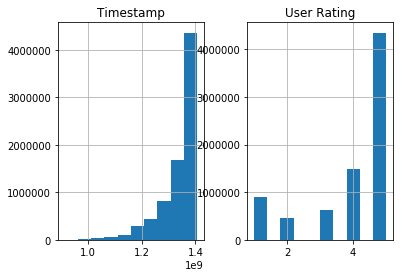

In [249]:
# Histogram of the numerical columns
elec_rating_df.hist()

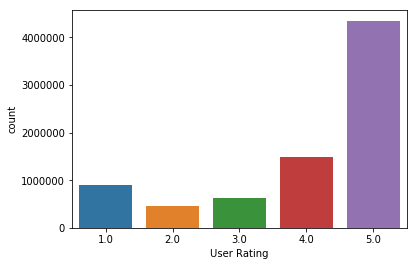

In [250]:
# Count plot to understand user rating distribution
sns.countplot(elec_rating_df["User Rating"])

### 2. Subset of the dataset

In [251]:
# Subset of the dataset with users who have given 50 or more ratings
def get_subset(data, min_rating_count):
    subset_filter = data["User Id"].value_counts() >= min_rating_count
    df = pd.DataFrame(subset_filter).reset_index()
    data = data[data["User Id"].isin(df[df["User Id"] == True]["index"].values)]
    return data

elec_rating_df = get_subset(elec_rating_df, 50)
elec_rating_df.head(10)

,User Id,Product Id,User Rating,Timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
118,AT09WGFUM934H,0594481813,3.0,1377907200
177,A32HSNCNPRUMTR,0970407998,1.0,1319673600
178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200
631,A3TAS1AG6FMBQW,0972683275,5.0,1353456000
1003,A2Y4H3PXB07WQI,0972683275,4.0,1292457600
1138,A25RTRAPQAJBDJ,0972683275,5.0,1329523200
1310,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1322,A1A5KUIIIHFF4U,1400501466,1.0,1332547200


### 3. Split Dataset into Train and Test set

In [252]:
# Splitting into train-test set for Collaborative Filtering using surprise train_test_split
reader = Reader(rating_scale=(0,5))
rating_data = Dataset.load_from_df(elec_rating_df[['User Id','Product Id','User Rating']], reader)
train_data, test_data = train_test_split(rating_data, test_size = 0.3, random_state=1)

### 4. Popularity Recommender Model

In [253]:
# This model function will be used in Section 7 while generating recommendations
def generate_popularity_ranking(data):
    # Group data by Product Id
    data_groupped = data.groupby(["Product Id"])
    # Generating mean rating and count of rating columns in the dataset
    mean_rating_df = data_groupped.agg({'User Rating':'mean'}).reset_index()
    rating_count_df = data_groupped.agg({'User Rating':'count'}).reset_index()
    rating_count_df.columns = ["Product Id", "Number of Rating"]
    ranking_data = pd.merge(mean_rating_df, rating_count_df, how="left", on=["Product Id"])
    # Generating feature 'Popularity Index' to determine ranking 
    # by taking into account of both Number of Ratings and Mean Rating
    # Popularity Index = (Rating Count/ Total Rating Count) * Mean Rating
    ranking_data["Rating Ratio"] = ranking_data["Number of Rating"]/sum(ranking_data["Number of Rating"])
    ranking_data["Popularity Index"] = ranking_data["Rating Ratio"] * ranking_data["User Rating"]
    ranking_data["Rank"] = ranking_data["Popularity Index"].rank(ascending=False, method='max')
    ranking_data.sort_values(["Rank"], ascending=True, inplace=True)
    return ranking_data

In [254]:
# Generating ranked data from original data
popularity_df = generate_popularity_ranking(elec_rating_df)
popularity_df.head(10)

,Product Id,User Rating,Number of Rating,Rating Ratio,Popularity Index,Rank
24827,B003ES5ZUU,4.864130,184,0.001462,0.007110,1.0
39003,B0088CJT4U,4.218447,206,0.001637,0.006904,2.0
11078,B000N99BBC,4.772455,167,0.001327,0.006332,3.0
38250,B007WTAJTO,4.701220,164,0.001303,0.006125,4.0
38615,B00829TIEK,4.436242,149,0.001184,0.005251,5.0
38611,B00829THK0,4.416058,137,0.001088,0.004807,6.0
39338,B008DWCRQW,4.094891,137,0.001088,0.004457,7.0
28761,B004CLYEDC,4.669492,118,0.000937,0.004377,8.0
21982,B002R5AM7C,4.125000,128,0.001017,0.004195,9.0
22460,B002V88HFE,4.698113,106,0.000842,0.003956,10.0


### 5. Collaborative Filtering Model

In [255]:
# Fitting SVD on the train set
recommender_model = SVD()
recommender_model.fit(train_data)

In [256]:
# Predictions for SVD model on the test set
prediction = recommender_model.test(test_data)
prediction

[Prediction(uid='A3PDWA32BAMB2Y', iid='B00CGW74YU', r_ui=5.0, est=4.21377483695197, details={'was_impossible': False}),
 Prediction(uid='A31BD4RXCON7QO', iid='B000P6G7YW', r_ui=1.0, est=4.2695298522443, details={'was_impossible': False}),
 Prediction(uid='A3J8A5L5AF5TX9', iid='B001GS8G06', r_ui=1.0, est=3.816610195130495, details={'was_impossible': False}),
 Prediction(uid='A3D6OI36USYOU1', iid='B000A1790S', r_ui=5.0, est=4.255353753596597, details={'was_impossible': False}),
 Prediction(uid='A3JU16JTNLVK1J', iid='B002CX16WO', r_ui=2.0, est=4.011546413503134, details={'was_impossible': False}),
 Prediction(uid='A1ZU55TM45Y2R8', iid='B00HFAEBWG', r_ui=3.0, est=3.629478939891256, details={'was_impossible': False}),
 Prediction(uid='AYP0YPLSP9ISM', iid='B006Z0Q2SI', r_ui=3.0, est=3.890693986776918, details={'was_impossible': False}),
 Prediction(uid='A3UR2N0ATGBCU8', iid='B0024NL4DI', r_ui=5.0, est=4.394094630871793, details={'was_impossible': False}),
 Prediction(uid='A1PM7HH4F77NEH', ii

In [257]:
# Attempted to get predictions using build_full_trainset() and build_anti_testset()
# Due to very large test dataset, not able to execute the code on local pc
# Predictions to be calculated using svds from scipy package in the next steps

# rating_data = Dataset.load_from_df(elec_rating_df[['User Id','Product Id','User Rating']], reader)

# train_data = rating_data.build_full_trainset()
# recommender_model = SVD()
# recommender_model.fit(train_data)

# test_data = train_data.build_anti_testset()
# prediction = recommender_model.test(testset)
# prediction

In [258]:
# Singular value Decomposition to generate matrix for rating prediction
rating_pivot = elec_rating_df.pivot_table(values="User Rating", index="User Id", columns="Product Id").fillna(0)
U, sigma, Vt = svds(rating_pivot, k = 5)
sigma = np.diag(sigma)
predicted_rating = np.dot(np.dot(U, sigma), Vt)

In [259]:
rating_pivot.head()

Product Id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User Id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
# Predictions dataframe to be used for recommendation
predicted_rating_df = pd.DataFrame(predicted_rating, columns = rating_pivot.columns, index=rating_pivot.index)
predicted_rating_df.head()

Product Id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User Id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.003392,0.005101,0.003110,0.014036,0.004347,0.003235,0.002712,0.000683,0.014522,0.002892,...,0.000628,0.045273,0.004108,0.065339,0.004514,0.007016,0.002378,0.149812,0.056574,0.015333
A100WO06OQR8BQ,0.002301,0.002763,0.004931,0.020029,0.009944,0.001969,0.011179,0.002130,0.010814,0.001776,...,0.000567,0.010756,0.002047,-0.011471,0.007097,-0.001310,0.003282,-0.027182,-0.011699,0.001592
A105S56ODHGJEK,-0.001665,-0.003039,0.002403,0.012232,0.006044,-0.002258,0.006311,0.002968,-0.004614,-0.001742,...,-0.000316,0.007457,-0.002645,-0.021967,0.016302,-0.002753,-0.000616,-0.018615,-0.011839,-0.006263
A105TOJ6LTVMBG,0.002522,0.003514,0.001841,0.007227,0.003489,0.002573,0.004060,-0.000115,0.009802,0.002169,...,0.000543,0.001348,0.002789,0.001661,-0.003795,0.000373,0.002574,-0.012402,-0.003682,0.004147
A10AFVU66A79Y1,0.000647,0.000271,0.001764,0.011201,0.005150,0.000247,0.005291,0.001642,0.002863,0.000320,...,0.000091,0.000177,0.000035,-0.016592,0.007257,-0.001789,0.001092,-0.025153,-0.013190,-0.001824


### 6. Model Evaluation

In [261]:
# RMSE for surprise.SVD model
accuracy.rmse(prediction)

RMSE: 0.9853


0.985327141399297

In [262]:
# RMSE for Singular Vector Decomposition based on rating matrix
rmse_df = rating_pivot - predicted_rating_df
rmse_df = rmse_df.apply(lambda x: x**2)
rmse = (rmse_df.sum().sum() / rmse_df.size)**0.5
print("RMSE :", rmse)

RMSE : 0.17790380135493164


### 7. Top - K Recommendation

In [263]:
# Functions to provide recommendations
def get_popularity_based_recommendation(popularity_data, k=5):
    recommendation_df = popularity_data.head(k)[["Product Id", "User Rating", "Number of Rating", "Rank"]]
    recommendation_df.set_index("Product Id", inplace=True)
    return recommendation_df

def get_svd_recommendation(prediction_data, k=5, num_users=3):
    recommendation_df = pd.DataFrame()
    prediction_df = prediction_data.copy()
    prediction_df.columns = prediction_df.columns.str.strip()
    prediction_df.index = prediction_df.index.str.strip()
    uid_list = prediction_df.index.unique().tolist()
    prediction_df = prediction_df.transpose()
    prediction_df = pd.DataFrame(prediction_df.to_records())
    
    for uid in uid_list[0: num_users]:
        sorted_rating_df = prediction_df[[uid, 'Product Id']].sort_values(uid, ascending=False)['Product Id'].head(k)
        recommendations = sorted_rating_df.values.tolist()
        temp_df = pd.DataFrame([",".join(recommendations)], index=[uid], columns=['Recommendations'])
        recommendation_df = recommendation_df.append(temp_df)

    return recommendation_df

In [264]:
# Main function which calls different functions based on which recommender has been provided as input
def get_top_k_recommendations(data, method, k=5, num_users=3):
    '''Returns the recommendations based on method [Popularity,SVD]'''
    if method.lower() == "popularity":
        return get_popularity_based_recommendation(data, k)
    elif method.lower() == "svd":
        return get_svd_recommendation(data, k, num_users)
    else:
        print("Please input valid method.")

In [265]:
# Getting Popularity Based Recommendations for k=5
get_top_k_recommendations(popularity_df, "Popularity", k=5)

,User Rating,Number of Rating,Rank
Product Id,,,
B003ES5ZUU,4.864130,184,1.0
B0088CJT4U,4.218447,206,2.0
B000N99BBC,4.772455,167,3.0
B007WTAJTO,4.701220,164,4.0
B00829TIEK,4.436242,149,5.0


In [266]:
# Getting Collaborative Filtering Based Recommendations for k=5
# num_user controls the number of users for which recommendation will be generated.
# for getting recommendation for all the users num_users = len(prediction_df.index.unique().tolist())
recommendation_df = get_top_k_recommendations(predicted_rating_df, 'SVD', num_users=3, k=5)
recommendation_df

,Recommendations
A100UD67AHFODS,"B007WTAJTO,B003ES5ZUU,B0082E9K7U,B00G4UQ6U8,B0..."
A100WO06OQR8BQ,"B0088CJT4U,B000N99BBC,B003ES5ZUU,B00829TIEK,B0..."
A105S56ODHGJEK,"B0088CJT4U,B00829TIEK,B000N99BBC,B008DWCRQW,B0..."


### 8. Insights

1. Popularity based recommendor gives same recommendation for all the users. To determine the popularity we have considered User ratings along with number of ratings per product.
2. Popularity based recommender from this code doesn't have the prediction power and it can only recommend the most popular products, hence computing rmse was not possible.
3. There are a lot of products with less number of ratings but with a rating of 5, however as we have considered number of ratings for a product as a criteria along with user rating hence these products were never recommended in popularity based recommender.  
4. SVD can be implemented using two modules
    
    a. Surprise - fit the model on train set and made predictions on test set, which resulted in rmse of 0.9855, to make recommendations based on this model we need to create a test set which has all the products that has not been rated by the user. Predictions are then made on this test set and recommendations are generated. Hoewever, given the size of dataset it is very computationally heavy to be run on the local system of average configuration.
    
    b. Scipy - svds method from this module decompose the rating matrix into three matrices, dot product of these matrices results in rating prediction matrix which has prediction of rating given by every user for all the products. This method was used to finally provide recommendations per user.